In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-11-2022)


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')

from Dataset_Creation import sys_dataset
import Dataset_load


## Read dataset

In [6]:

scale  = 0.05
scaled_amplitude = Parameter('amplitude',
                             value = 4.11e-11 * scale)
dataset_asimov  = Dataset_load.create_asimov(model = 'pl', source = "PKS", 
                                            parameters = Parameters([scaled_amplitude]))

## Single Cases

In [7]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

shift_neg = +0.1
tilt_neg = +0.015

print(tilt_neg)



0.015


In [8]:

sys = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_neg, 
                        tilt = tilt_neg,
                        rnd = False)
dataset = sys.create_dataset()

dataset_N = sys.create_dataset_N(e_reco_n = 10)
zero = 1e-24
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [ 1/zero**2, 1/zero**2,1/shift_neg**2, 1/tilt_neg**2,])

dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
if tilt_neg >zero:
    dataset_N.irf_model.eff_area_model.parameters['tilt_nuisance'].frozen = False

In [9]:
%%time
fit = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit.optimize_opts = minuit_opts
result = fit.run(dataset)


CPU times: user 16 s, sys: 3.86 s, total: 19.9 s
Wall time: 19.9 s


In [10]:
%%time
fit_N = Fit(store_trace=False)
fit_N.optimize_opts = minuit_opts
result_N = fit_N.run(dataset_N)


CPU times: user 10min 44s, sys: 17min 42s, total: 28min 27s
Wall time: 6min 37s


## Correlation

In [11]:
from gammapy.modeling.fit import Registry
registry= Registry()

def covariance_ (fit_compute, datasets_compute, parameters_plot = None):
    parameters= Parameters.from_stack([datasets_compute.models.parameters])
    parameters = parameters.free_parameters

    kwargs = fit_compute.covariance_opts.copy()
    kwargs["minuit"] = fit_compute.minuit
    backend = kwargs.pop("backend", fit_compute.backend)
    compute = registry.get("covariance", backend)

    with parameters.restore_status():
        if fit_compute.backend == "minuit":
            method = "hesse"
        else:
            method = ""
        factor_matrix, info = compute(
            parameters=parameters, function=datasets_compute.stat_sum, **kwargs
        )
        covariance = Covariance.from_factor_matrix(
            parameters=parameters, matrix=factor_matrix
        )
        if parameters_plot is not None:
            covariance = covariance.get_subcovariance(parameters_plot)
    return covariance

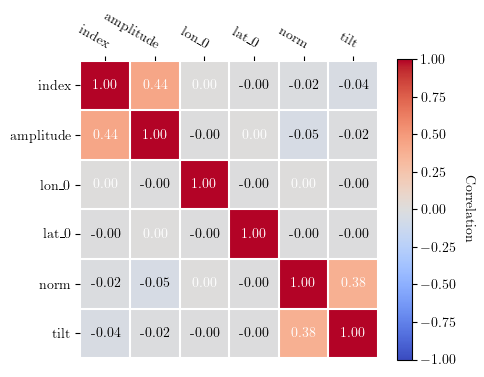

In [12]:
covariance  = covariance_(fit, dataset)
covariance.plot_correlation()


fig = plt.gcf()
fig.savefig("plots/3_corr_matrix_standard.png")

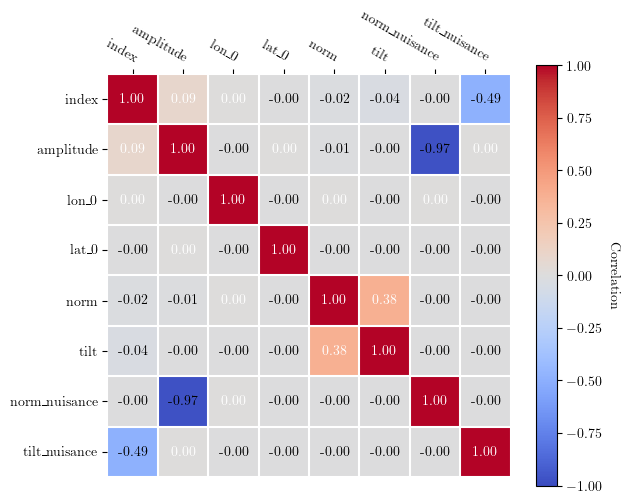

In [13]:
par_names = ['index', 'amplitude', 'lon_0', 'lat_0', 'norm', 'tilt', 'norm_nuisance', 'tilt_nuisance']
parameters = Parameters([dataset_N.models.parameters[name] for name in par_names])
covariance_N_cut  = covariance_(fit_N, dataset_N, parameters )
covariance_N_cut.plot_correlation()


fig = plt.gcf()
plt.tight_layout()
fig.savefig("plots/3_corr_matrix_nuisance.png")

In [14]:
(dataset_N.models.parameters.to_table())

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str12,str13,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.2857e+00,,3.043e-02,nan,nan,False,False,False,
spectral,amplitude,1.8700e-12,cm-2 s-1 TeV-1,1.941e-13,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,
spatial,lon_0,3.2968e+02,deg,1.283e-03,3.287e+02,3.307e+02,False,False,False,
spatial,lat_0,-3.0222e+01,deg,1.112e-03,-3.122e+01,-2.922e+01,False,False,False,
spectral,norm,1.0000e+00,,1.218e-02,nan,nan,False,True,False,
spectral,tilt,3.3568e-06,,1.398e-02,nan,nan,False,False,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,
e_reco_model,bias,-1.1342e-39,,1.000e-24,nan,nan,False,False,True,


In [15]:
(dataset.models.parameters.to_table())

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.2857e+00,,2.655e-02,nan,nan,False,False,False,
spectral,amplitude,1.8700e-12,cm-2 s-1 TeV-1,4.686e-14,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,
spatial,lon_0,3.2968e+02,deg,1.283e-03,3.287e+02,3.307e+02,False,False,False,
spatial,lat_0,-3.0222e+01,deg,1.112e-03,-3.122e+01,-2.922e+01,False,False,False,
spectral,norm,1.0000e+00,,1.218e-02,nan,nan,False,True,False,
spectral,tilt,4.4253e-06,,1.398e-02,nan,nan,False,False,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,
